# Introduction

Welcome to Binary Classification with Bank Churn Dataset competition! Here we will predict a customer churn based on their information. The dataset contains 13 columns:

1. Customer ID: A unique identifier for each customer
2. Surname: The customer's surname or last name
3. Credit Score: A numerical value representing the customer's credit score
4. Geography: The country where the customer resides (France, Spain or Germany)
5. Gender: The customer's gender (Male or Female)
6. Age: The customer's age.
7. Tenure: The number of years the customer has been with the bank
8. Balance: The customer's account balance
9. NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
10. HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
11. IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
12. EstimatedSalary: The estimated salary of the customer
13. Exited: Whether the customer has churned (1 = yes, 0 = no)

The metric we will use is Area Under the ROC Curve. If you want to read the description of the original dataset, you can visit this page: https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction

# Loading Libraries and Datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna

from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

/Applications/miniconda3/envs/playground/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train = pd.read_csv('data/train.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
test = pd.read_csv('data/test.csv', index_col = 'id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
orig_train = pd.read_csv('data/Churn_Modelling.csv', index_col = 'RowNumber')

# Descriptive Statistics

Let's begin by taking a peek at our training dataset first

In [7]:
train.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1,0,136024.31,1
6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1,0,29792.11,0
7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1,0,106851.60,0
8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1,0,142917.13,0


In [8]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc['min'] = train.min()
desc['max'] = train.max()
#desc['list_unique'] = ",".join(train.unique())
desc

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4
HasCrCard,uint8,165034,2,0.001212,0,0.0,0,1


We can see that we have 165k rows and 13 columns, including our target here, which makes it 12 features, with at least 3 of them being categorical.

Let's see the test dataset now.

In [9]:
test.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0,1,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1,0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1,0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1,0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1,0,139431.00
165039,15672704,Pearson,593,France,Female,22.0,9,0.00,2,0,0,51907.72
165040,15647838,Onyemere,682,Spain,Male,45.0,4,0.00,2,1,1,157878.67
165041,15775307,Hargreaves,539,Spain,Female,47.0,8,0.00,2,1,1,126784.29
165042,15653937,Hsueh,845,France,Female,47.0,3,111096.91,1,1,0,94978.10


In [10]:
desc = pd.DataFrame(index = list(test))
desc['type'] = test.dtypes
desc['count'] = test.count()
desc['nunique'] = test.nunique()
desc['%unique'] = desc['nunique'] / len(test) * 100
desc['null'] = test.isnull().sum()
desc['%null'] = desc['null'] / len(test) * 100
desc['min'] = test.min()
desc['max'] = test.max()
desc

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,110023,19698,17.903529,0,0.0,15565701,15815690
Surname,object,110023,2708,2.461304,0,0.0,Abazu,Zuyeva
CreditScore,int64,110023,454,0.412641,0,0.0,350,850
Geography,object,110023,3,0.002727,0,0.0,France,Spain
Gender,object,110023,2,0.001818,0,0.0,Female,Male
Age,float64,110023,74,0.067259,0,0.0,18.0,92.0
Tenure,int64,110023,11,0.009998,0,0.0,0,10
Balance,float64,110023,22513,20.462085,0,0.0,0.0,250898.09
NumOfProducts,int64,110023,4,0.003636,0,0.0,1,4
HasCrCard,uint8,110023,2,0.001818,0,0.0,0,1


On the test dataset, we have 110k rows. There is also no missing value on both.

Finally, let's try to see the original dataset.

In [11]:
orig_train.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0


In [12]:
desc = pd.DataFrame(index = list(orig_train))
desc['type'] = orig_train.dtypes
desc['count'] = orig_train.count()
desc['nunique'] = orig_train.nunique()
desc['%unique'] = desc['nunique'] / len(orig_train) * 100
desc['null'] = orig_train.isnull().sum()
desc['%null'] = desc['null'] / len(orig_train) * 100
desc['min'] = orig_train.min()
desc['max'] = orig_train.max()
desc

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,10000,10000,100.00,0,0.0,15565701,15815690
Surname,object,10000,2932,29.32,0,0.0,Abazu,Zuyeva
CreditScore,int64,10000,460,4.60,0,0.0,350,850
Geography,object,10000,3,0.03,0,0.0,France,Spain
Gender,object,10000,2,0.02,0,0.0,Female,Male
Age,int64,10000,70,0.70,0,0.0,18,92
Tenure,int64,10000,11,0.11,0,0.0,0,10
Balance,float64,10000,6382,63.82,0,0.0,0.0,250898.09
NumOfProducts,int64,10000,4,0.04,0,0.0,1,4
HasCrCard,int64,10000,2,0.02,0,0.0,0,1


In [13]:
numerical_features = list(test._get_numeric_data())
categorical_features = list(test.drop(numerical_features, axis = 1))

# Preparation

This is where we start preparing everything if we want to start building machine learning models.

In [14]:
X = pd.concat([orig_train, train]).reset_index(drop = True)
y = X.pop('Exited')

orig_comp_combo = train.merge(orig_train, on = list(test), how = 'left')
orig_comp_combo.index = train.index

orig_test_combo = test.merge(orig_train, on = list(test), how = 'left')
orig_test_combo.index = test.index

seed = 42
splits = 30

skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

/var/folders/3v/836xbswd3z1f339m_2k6w7b80000gn/T/ipykernel_3860/2227394479.py:4: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  orig_comp_combo = train.merge(orig_train, on = list(test), how = 'left')
/var/folders/3v/836xbswd3z1f339m_2k6w7b80000gn/T/ipykernel_3860/2227394479.py:7: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  orig_test_combo = test.merge(orig_train, on = list(test), how = 'left')


# Feature Engineering

In [15]:
def nullify(x):
    x_copy = x.copy()
    x_copy['Balance'] = x_copy['Balance'].replace({0 : np.nan})
    return x_copy

Nullify = FunctionTransformer(nullify)

In [16]:
def salary_rounder(x):
    x_copy = x.copy()
    x_copy['EstimatedSalary'] = (x_copy['EstimatedSalary'] * 100).astype(np.uint64)
    return x_copy

SalaryRounder = FunctionTransformer(salary_rounder)

In [17]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age'] * 10).astype(np.uint16)
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)

In [18]:
def balance_rounder(x):
    x_copy = x.copy()
    x_copy['Balance'] = (x_copy['Balance'] * 100).astype(np.uint64)
    return x_copy

BalanceRounder = FunctionTransformer(balance_rounder)

In [19]:
def feature_generator(x):
    
    x_copy = x.copy()
    #x_copy['IsSenior'] = (x_copy['Age'] >= 600).astype(np.uint8)
    x_copy['IsActive_by_CreditCard'] = x_copy['HasCrCard'] * x_copy['IsActiveMember']
    x_copy['Products_Per_Tenure'] =  x_copy['Tenure'] / x_copy['NumOfProducts']
    x_copy['ZeroBalance'] = (x_copy['Balance'] == 0).astype(np.uint8)
    x_copy['AgeCat'] = np.round(x_copy.Age/20).astype(np.uint16)#.astype('category')
    x_copy['AllCat'] = x_copy['Surname']+x_copy['Geography']+x_copy['Gender']+x_copy.EstimatedSalary.astype('str')+x_copy.CreditScore.astype('str')+x_copy.Age.astype('str')+x_copy.NumOfProducts.astype('str')+x_copy.Tenure.astype('str')+x_copy.CustomerId.astype('str')#+np.round(x_copy.IsActiveMember).astype('str')
    
    return x_copy

FeatureGenerator = FunctionTransformer(feature_generator)

In [20]:
def svd_rounder(x):
    
    x_copy = x.copy()
    for col in [column for column in list(x) if 'SVD' in column]:
        x_copy[col] = (x_copy[col] * 1e18).astype(np.int64)
        
    return x_copy

SVDRounder = FunctionTransformer(svd_rounder)

In [21]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [22]:
class Categorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols : list):
        self.cols = cols
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x.astype({cat : 'category' for cat in self.cols})

In [23]:
class Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_features = 1000, cols = ['Surname'], n_components = 3):
        self.max_features = max_features
        self.cols = cols
        self.n_components = n_components
        
    def fit(self, x, y):
        self.vectorizer_dict = {}
        self.decomposer_dict = {}
        
        for col in self.cols:
            self.vectorizer_dict[col] = TfidfVectorizer(max_features = self.max_features).fit(x[col].astype(str), y)
            self.decomposer_dict[col] = TruncatedSVD(random_state = seed, n_components = self.n_components).fit(
                self.vectorizer_dict[col].transform(x[col].astype(str)), y
            )
        
        return self
    
    def transform(self, x):
        vectorized = {}
        
        for col in self.cols:
            vectorized[col] = self.vectorizer_dict[col].transform(x[col].astype(str))
            vectorized[col] = self.decomposer_dict[col].transform(vectorized[col])
        
        vectorized_df = pd.concat([pd.DataFrame(vectorized[col]).rename({
            f'truncatedsvd{i}' : f'{col}SVD{i}' for i in range(self.n_components)
        }, axis = 1) for col in self.cols], axis = 1)
        
        return pd.concat([x.reset_index(drop = True), vectorized_df], axis = 1)

# Model Cross Validation

Let's start by evaluating the performance of our model first. We will use M-Estimate Encoder and Standard Scaler in our pipeline. We will also concatenate the original dataset only during the cross-validation process for robustness.

In [24]:
def cross_val_score(estimator, cv = skf, label = '', include_original = True, show_importance = False, add_reverse = False):
    
    X = train.copy()
    y = X.pop('Exited')
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores= [], []
    
    feature_importances_table = pd.DataFrame({'value' : 0}, index = list(X.columns))
    
    test_predictions = np.zeros((len(test)))
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        #define validation set
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        if include_original:
            X_train = pd.concat([orig_train.drop('Exited', axis = 1), X_train]).reset_index(drop = True)
            y_train = pd.concat([orig_train.Exited, y_train]).reset_index(drop = True)
            
        if add_reverse:
            X_train = pd.concat([X_train, X_train.iloc[::-1]]).reset_index(drop = True)
            y_train = pd.concat([y_train, y_train.iloc[::-1]]).reset_index(drop = True)
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        val_predictions[val_idx] += val_preds
        test_predictions += model.predict_proba(test)[:, 1] / cv.get_n_splits()
        if show_importance:
            feature_importances_table['value'] += permutation_importance(model, X_val, y_val, random_state = seed, scoring = make_scorer(roc_auc_score, needs_proba = True), n_repeats = 5).importances_mean / cv.get_n_splits()
        
        #evaluate model for a fold
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        #print(f'Fold {fold}: {val_score:.5f}')
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
       
    if show_importance:
        plt.figure(figsize = (20, 30))
        plt.title(f'Features with Biggest Importance of {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} Model', size = 25, weight = 'bold')
        sns.barplot(feature_importances_table.sort_values('value', ascending = False).T, orient = 'h', palette = 'viridis')
        plt.show()
    else:
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
        
    val_predictions = np.where(orig_comp_combo.Exited_y == 1, 0, np.where(orig_comp_combo.Exited_y == 0, 1, val_predictions))
    test_predictions = np.where(orig_test_combo.Exited == 1, 0, np.where(orig_test_combo.Exited == 0, 1, test_predictions))
    
    return val_scores, val_predictions, test_predictions

In [25]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

cat_features = ['CustomerId', 'Surname', 'EstimatedSalary', 'Geography', 'Gender', 'Tenure', 'Age', 'NumOfProducts', 'IsActiveMember', 'CreditScore', 'AllCat', 'IsActive_by_CreditCard']

# Logistic Regression

In [ ]:
Log = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CreditScore'], max_features = 500, n_components = 4),
    CatBoostEncoder(cols = cat_features + [f'SurnameSVD{i}' for i in range(4)]),# + [f'AllCatSVD{i}' for i in range(6)] + [f'EstimatedSalarySVD{i}' for i in range(6)] + [f'CreditScoreSVD{i}' for i in range(6)]),
    StandardScaler(),
    LogisticRegression(random_state = seed, max_iter = 1000000000)
)

_, oof_list['Log'], predict_list['Log'] = cross_val_score(Log)

# Tensorflow

In [ ]:
class TensorFlower(BaseEstimator, ClassifierMixin):
    
    def fit(self, x, y):
        inputs = tf.keras.Input((x.shape[1]))
        inputs_norm = tf.keras.layers.BatchNormalization()(inputs)
        
        z = tf.keras.layers.Dense(32)(inputs_norm)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(64)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(16)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(4)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.LeakyReLU()(z)
        #z = tf.keras.layers.Dropout(.4)(z)
        
        z = tf.keras.layers.Dense(1)(z)
        z = tf.keras.layers.BatchNormalization()(z)
        outputs = tf.keras.activations.sigmoid(z)
        
        self.model = tf.keras.Model(inputs, outputs)
        self.model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.AdamW(1e-4))
        
        self.model.fit(x.to_numpy(), y, epochs = 10, verbose = 0)
        self.classes_ = np.unique(y)
        
        return self
    def predict_proba(self, x):
        predictions = np.zeros((len(x), 2))
        predictions[:, 1] = self.model.predict(x, verbose = 0)[:, 0]
        predictions[:, 0] = 1 - predictions[:, 1]
        return predictions
    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis = 1)

In [ ]:
TensorFlowey = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    #Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CreditScore'], max_features = 500, n_components = 6),
    CatBoostEncoder(cols = cat_features),
    TensorFlower()
)

_, oof_list['TF'], predict_list['TF'] = cross_val_score(TensorFlowey)

Val Score: 0.89236 ± 0.00480 | Train Score: 0.88795 ± 0.00225 | 


# XGBoost

In [ ]:
def xgb_objective(trial):
    params = {
        'eta' : trial.suggest_float('eta', .001, .3, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 30),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', .1, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 20, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .01, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .01, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : seed,
        'tree_method' : 'hist',
    }
    
    optuna_model = make_pipeline(
        SalaryRounder,
        AgeRounder,
        FeatureGenerator,
        Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CustomerId'], max_features = 1000, n_components = 3),
        CatBoostEncoder(cols = ['CustomerId', 'Surname', 'EstimatedSalary', 'AllCat', 'CreditScore']),
        MEstimateEncoder(cols = ['Geography', 'Gender']),
        XGBClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

xgb_study = optuna.create_study(direction = 'maximize')

[I 2024-01-30 03:52:38,583] A new study created in memory with name: no-name-42bf8d46-9f5a-4df9-996a-26ab6301462f


In [ ]:
#xgb_study.optimize(xgb_objective, 50)

In [ ]:
xgb_params = {'eta': 0.04007938900538817, 'max_depth': 5, 'subsample': 0.8858539721226424, 'colsample_bytree': 0.41689519430449395, 'min_child_weight': 0.4225662401139526, 'reg_lambda': 1.7610231110037127, 'reg_alpha': 1.993860687732973}

XGB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat', 'EstimatedSalary', 'CustomerId'], max_features = 1000, n_components = 3),
    CatBoostEncoder(cols = ['CustomerId', 'Surname', 'EstimatedSalary', 'AllCat', 'CreditScore']),
    MEstimateEncoder(cols = ['Geography', 'Gender']),
    XGBClassifier(**xgb_params, random_state = seed, tree_method = 'hist', n_estimators = 1000)
)

_, oof_list['XGB'], predict_list['XGB'] = cross_val_score(XGB, show_importance = False)

Val Score: 0.89619 ± 0.00457 | Train Score: 0.90199 ± 0.00037 | 


# LightGBM

In [ ]:
def lgb_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : seed,
        #'boosting_type' : 'dart',
    }
    
    optuna_model = make_pipeline(
        SalaryRounder,
        AgeRounder,
        FeatureGenerator,
        Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 3),
        CatBoostEncoder(cols = ['Surname', 'AllCat', 'CreditScore', 'Age']),
        MEstimateEncoder(cols = ['Geography', 'Gender', 'NumOfProducts']),
        StandardScaler(),
        LGBMClassifier(**params)
    )
    
    optuna_score, _, _ = cross_val_score(optuna_model)
    
    return np.mean(optuna_score)

lgb_study = optuna.create_study(direction = 'maximize')

[I 2024-01-30 04:11:16,995] A new study created in memory with name: no-name-8b1f287e-c96e-49f5-b35b-836831951bff


In [ ]:
#lgb_study.optimize(lgb_objective, 100)

In [ ]:
lgb_params = {'learning_rate': 0.01864960338160943, 'max_depth': 9, 'subsample': 0.6876252164703066, 'min_child_weight': 0.8117588782708633, 'reg_lambda': 6.479178739677389, 'reg_alpha': 3.2952573115561234}

LGB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 3),
    CatBoostEncoder(cols = ['Surname', 'AllCat', 'CreditScore', 'Age']),
    MEstimateEncoder(cols = ['Geography', 'Gender', 'NumOfProducts']),
    StandardScaler(),
    LGBMClassifier(**lgb_params, random_state = seed, n_estimators = 1000)
)

_, oof_list['LGB'], predict_list['LGB'] = cross_val_score(LGB, show_importance = False)

Val Score: 0.89566 ± 0.00482 | Train Score: 0.90018 ± 0.00027 | 


# CatBoost

In [ ]:
CB = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], has_time = True)
)

_, oof_list['CB'], predict_list['CB'] = cross_val_score(CB, show_importance = False)

Val Score: 0.90305 ± 0.00432 | Train Score: 0.58026 ± 0.07246 | 


In [ ]:
CB_Bayes = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], bootstrap_type = 'Bayesian', has_time = True)
)

_, oof_list['CB_Bayes'], predict_list['CB_Bayes'] = cross_val_score(CB_Bayes, show_importance = False)

Val Score: 0.90278 ± 0.00429 | Train Score: 0.50217 ± 0.09963 | 


In [ ]:
CB_Bernoulli = make_pipeline(
    SalaryRounder,
    AgeRounder,
    FeatureGenerator,
    Vectorizer(cols = ['Surname', 'AllCat'], max_features = 1000, n_components = 4),
    SVDRounder,
    CatBoostClassifier(random_state = seed, verbose = 0, cat_features = cat_features + [f'SurnameSVD{i}' for i in range(4)], bootstrap_type = 'Bernoulli', has_time = True)
)

_, oof_list['CB_Bernoulli'], predict_list['CB_Bernoulli'] = cross_val_score(CB_Bernoulli, show_importance = False)

Val Score: 0.90295 ± 0.00426 | Train Score: 0.52507 ± 0.10903 | 


# Voting Ensemble

In [ ]:
weights = RidgeClassifier(random_state = seed).fit(oof_list, train.Exited).coef_[0]
weights /= weights.sum()
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])

,weight per model
Log,-0.019814
TF,0.030625
XGB,-0.018801
LGB,0.128685
CB,0.370633
CB_Bayes,0.241021
CB_Bernoulli,0.267651


In [ ]:
#_, ensemble_oof, predictions = cross_val_score(voter, show_importance = False)
print(f'Score: {(roc_auc_score(train.Exited, oof_list.to_numpy() @ weights)):.5f}')
predictions = predict_list.to_numpy() @ weights

Score: 0.90498


# Submission

In [ ]:
submission = test.copy()
submission['Exited'] = np.where(orig_test_combo.Exited == 1, 0, np.where(orig_test_combo.Exited == 0, 1, predictions))

submission.Exited.to_csv('submission.csv')

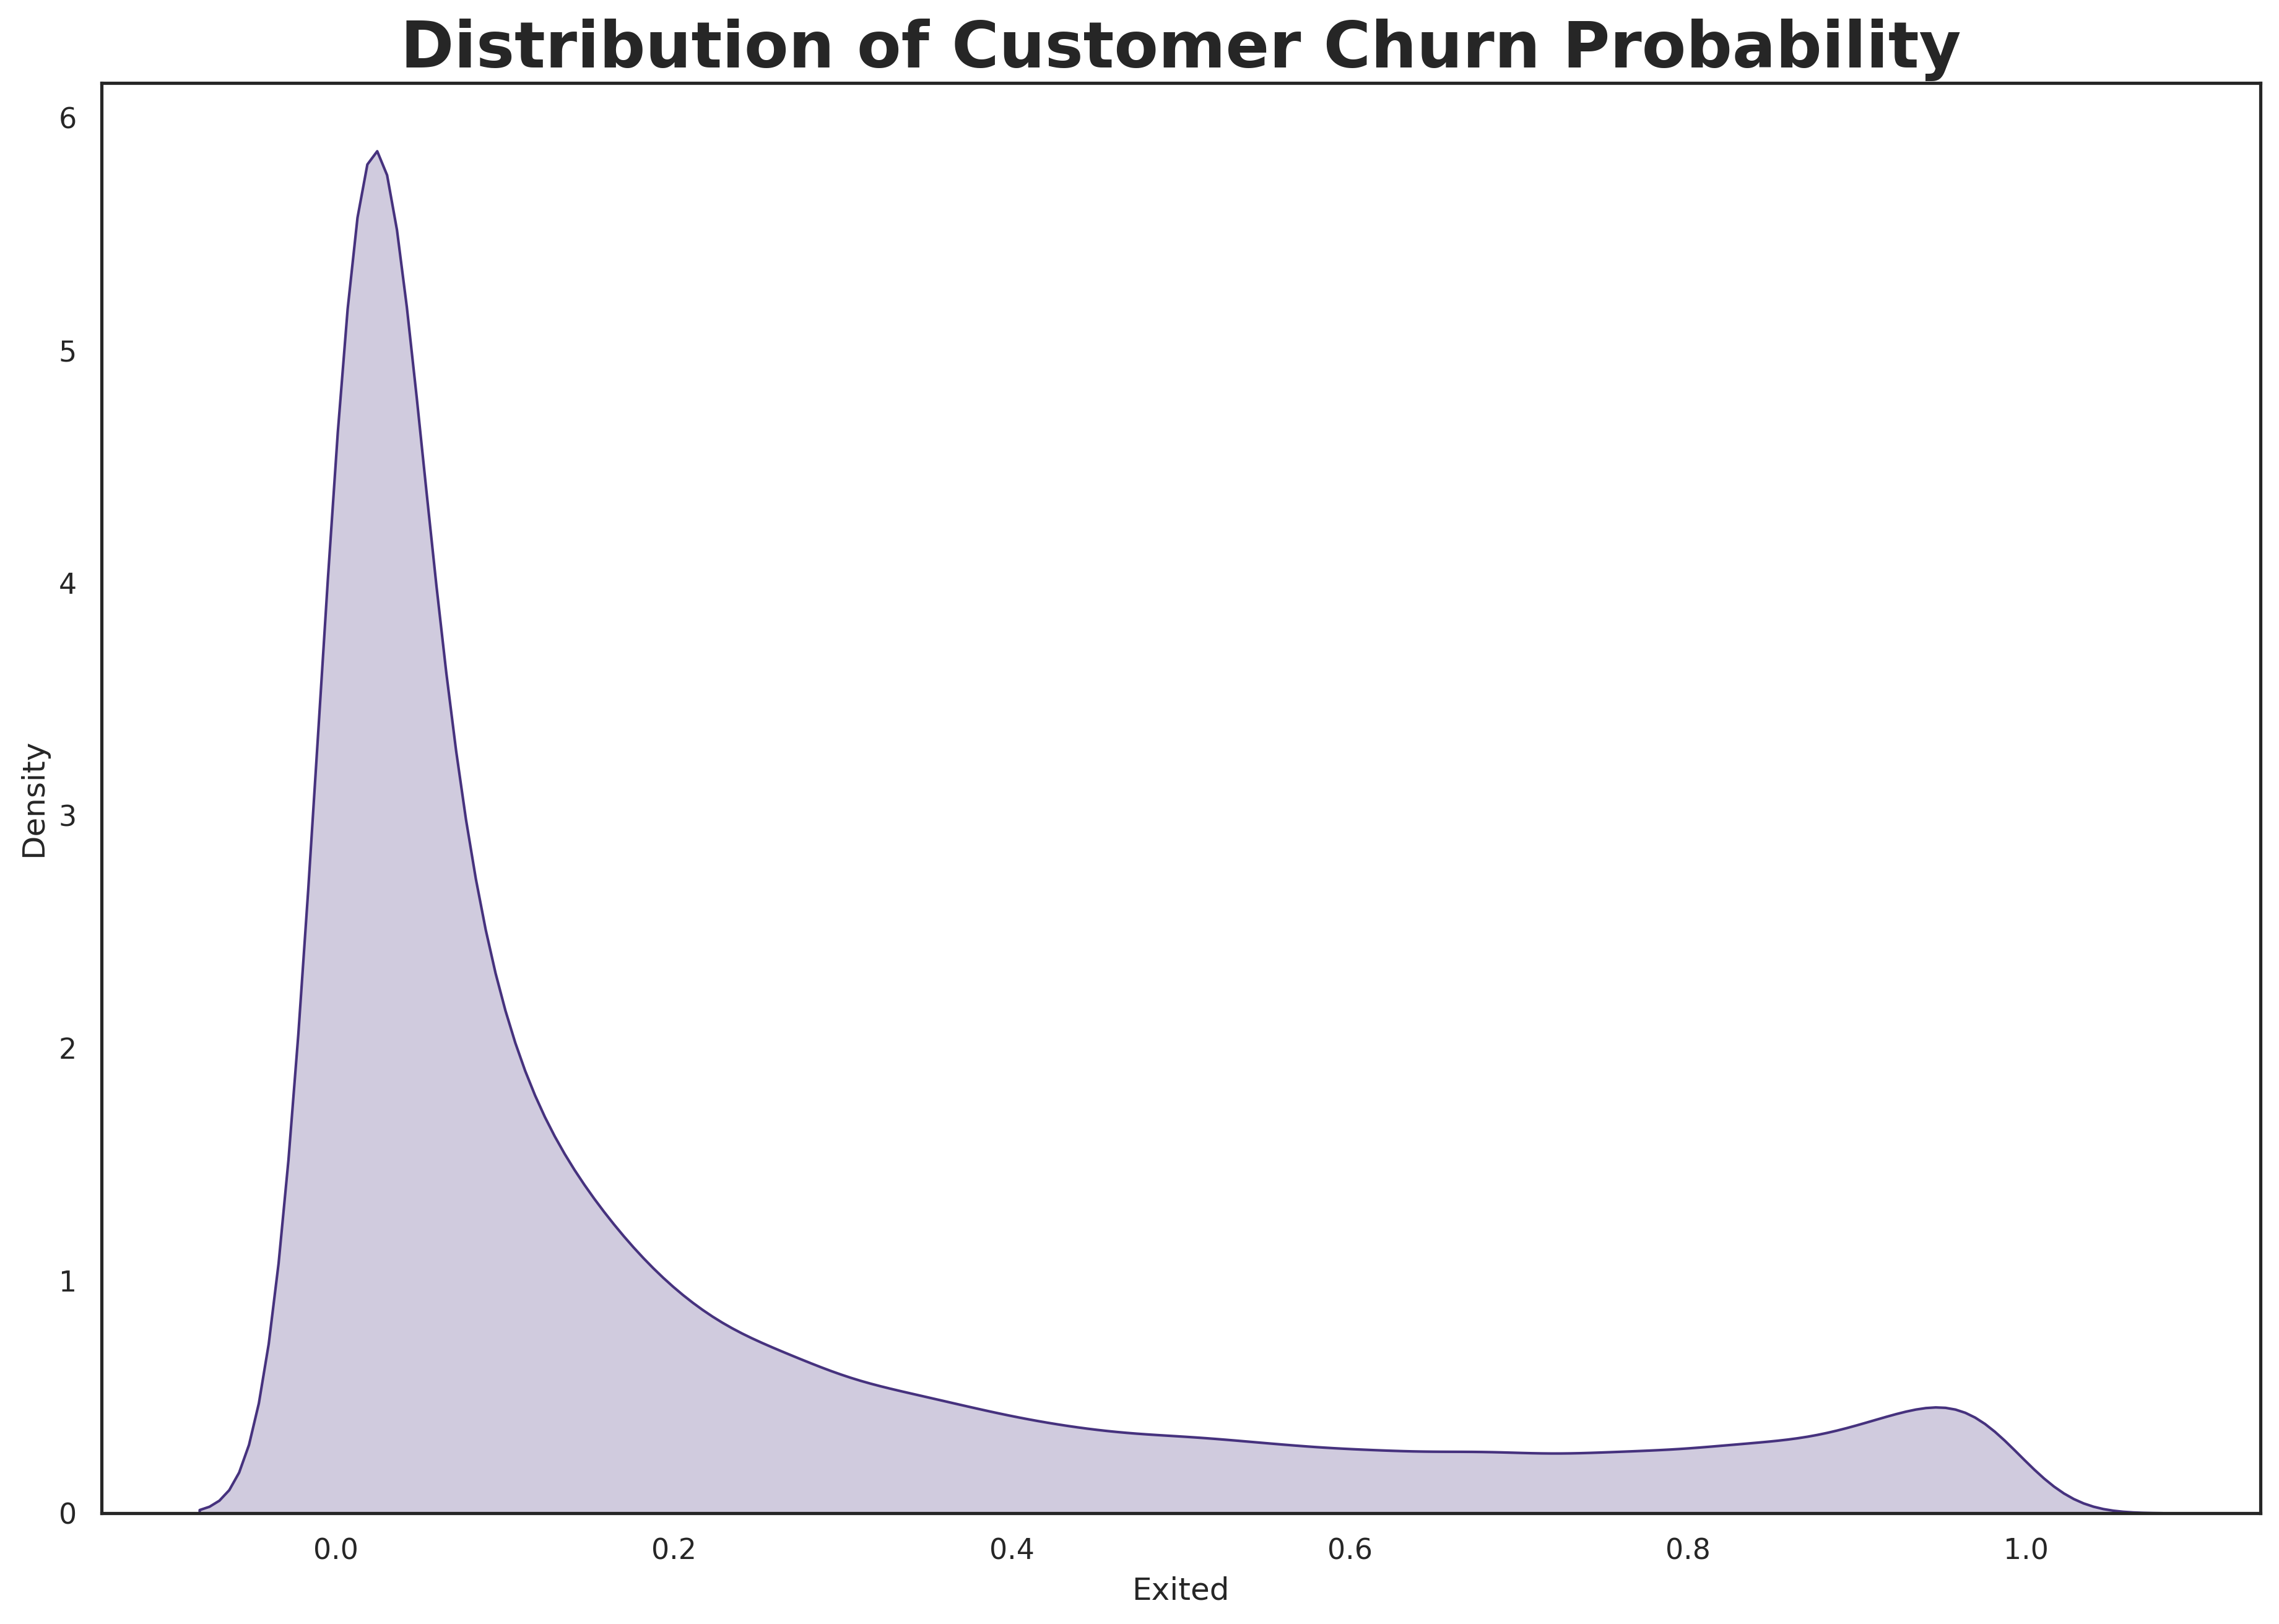

In [ ]:
plt.figure(figsize = (15, 10), dpi = 300)
sns.kdeplot(submission.Exited, fill = True)
plt.title("Distribution of Customer Churn Probability", weight = 'bold', size = 25)
plt.show()

Thanks for reading!